Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format="retina"
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import datetime
import random
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim
import math
from IPython import display
import csv
from copy import deepcopy as dc
import time

import yfinance as yf

Load the stock data into initial csv file for pre-processing using the Yahoo Finance Python library.

In [2]:
# Define the ticker symbol for Stock
ticker_symbol = "^GSPC"

# Set the start and end dates
start_date = "1982-04-20"
end_date = "2023-06-07"

# Fetch the historical data from Yahoo Finance
stock_data = yf.download(ticker_symbol, start=start_date, end=end_date)

stock_data.to_csv("stock_data.csv")

api_data = ["Open","Close"]

# Extract only the "Date", "Open", and "Close" columns
selected_data = stock_data[api_data].reset_index()

# Save the selected data to a CSV file
selected_data.to_csv("stock_data.csv", index=False)

[*********************100%***********************]  1 of 1 completed


This function replaces the Open and Close column for one column called Average which contains the average of the open and close values for the corresponding day.

In [3]:
def CSVAverage(input_file, output_file, column_iters):
  firstLine = True
  with open(input_file, 'r') as input_csv, open(output_file, 'w', newline='') as output_csv:
    reader = csv.reader(input_csv)
    writer = csv.writer(output_csv)

    for line in reader:
      if firstLine:
        inst = [0, 0]
        inst[0] = line[0]
        inst[1] = "Average"
        writer.writerow(inst)
        firstLine = False
        continue
      inst = [0, 0]
      inst[0] = line[0]
      for x in range(column_iters):
        inst[1] += float(line[x + 1])
      inst[1] = float(inst[1])/column_iters
      writer.writerow(inst)

Defines the function for loading n_steps number of inputs into a single row for each row. This is the function that makes the sequence for the model to look at.

In [4]:
def prep_dataframe(df, n_steps):
  df = dc(df)

  df.set_index('Date', inplace=True)

  for i in range(1, n_steps+1):
    df[f'Average(t-{i})'] = df['Average'].shift(i)

  df.dropna(inplace=True)

  return df

Sets the files for inputs and outputs

In [5]:
# Get input and output file names
input_file = "stock_data.csv"
output_file = "average_stock_data.csv"

# Printing input_file (Has Date, Open, and Close columns)
input_data = pd.read_csv(input_file)
input_data

,Date,Open,Close
0,1982-04-20,115.800003,115.440002
1,1982-04-21,115.480003,115.720001
2,1982-04-22,115.720001,117.190002
3,1982-04-23,118.019997,118.639999
4,1982-04-26,118.940002,119.260002
...,...,...,...
10365,2023-05-31,4190.740234,4179.830078
10366,2023-06-01,4183.029785,4221.020020
10367,2023-06-02,4241.009766,4282.370117
10368,2023-06-05,4282.990234,4273.790039


Call the CSVAverage function to get a new file that contains a Date and Average column.

In [6]:
CSVAverage(input_file, output_file, len(api_data))

# Printing the output_file (Has Date and Average columns)
stock_data = pd.read_csv(output_file)
stock_data

,Date,Average
0,1982-04-20,115.620003
1,1982-04-21,115.600002
2,1982-04-22,116.455002
3,1982-04-23,118.329998
4,1982-04-26,119.100002
...,...,...
10365,2023-05-31,4185.285156
10366,2023-06-01,4202.024902
10367,2023-06-02,4261.689941
10368,2023-06-05,4278.390137


Plotting Stock Data (Date, Average Price)

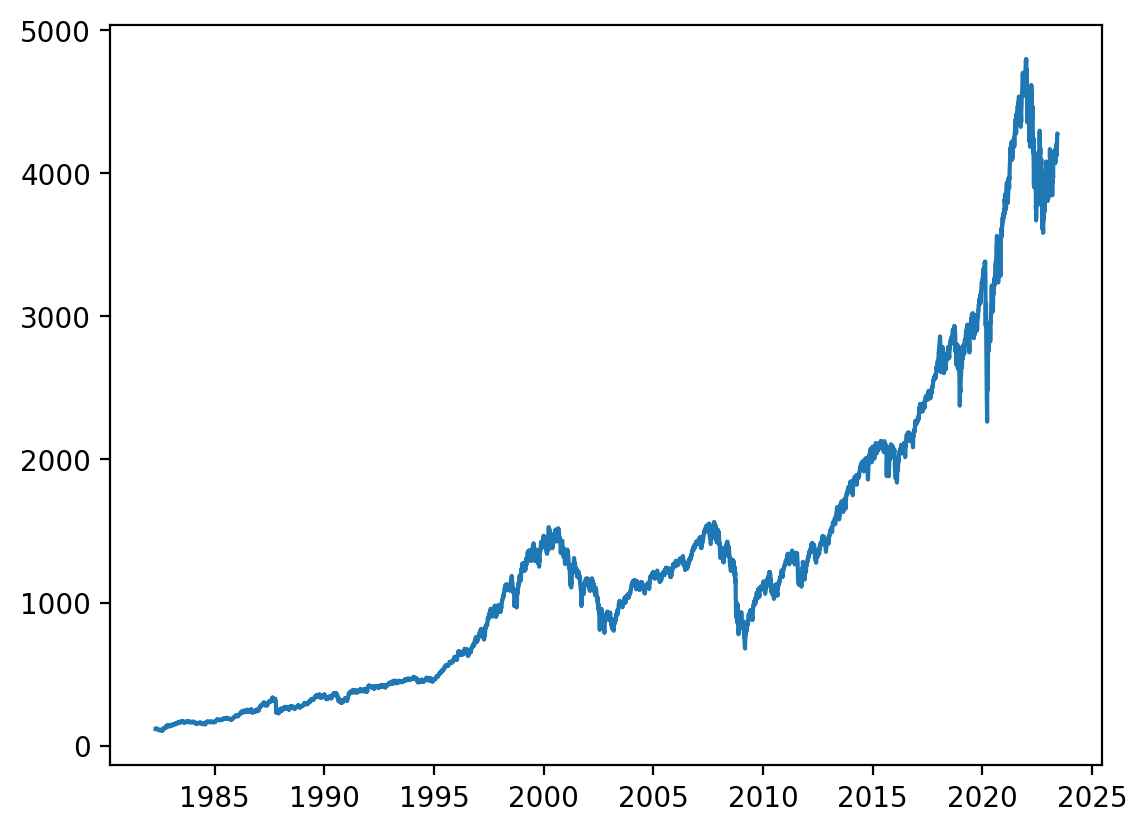

In [7]:
stock_data['Date'] = pd.to_datetime(stock_data['Date'])

plt.plot(stock_data['Date'], stock_data['Average'])

Defining how many days of lookback (time sequence) the model will have as input data for the given day it is trying to predict the average price for.

In [8]:
lookback = 25

shifted_df = prep_dataframe(stock_data, lookback)
shifted_df

,Average,Average(t-1),Average(t-2),Average(t-3),Average(t-4),Average(t-5),Average(t-6),Average(t-7),Average(t-8),Average(t-9),...,Average(t-16),Average(t-17),Average(t-18),Average(t-19),Average(t-20),Average(t-21),Average(t-22),Average(t-23),Average(t-24),Average(t-25)
Date,,,,,,,,,,,,,,,,,,,,,
1982-05-25,114.950001,114.625000,114.959999,114.719997,115.250000,116.094997,117.165001,118.105000,118.650002,119.529999,...,116.389999,116.325001,116.270000,117.545002,118.535000,119.100002,118.329998,116.455002,115.600002,115.620003
1982-05-26,113.395000,114.950001,114.625000,114.959999,114.719997,115.250000,116.094997,117.165001,118.105000,118.650002,...,117.435001,116.389999,116.325001,116.270000,117.545002,118.535000,119.100002,118.329998,116.455002,115.600002
1982-05-27,112.885002,113.395000,114.950001,114.625000,114.959999,114.719997,115.250000,116.094997,117.165001,118.105000,...,117.759998,117.435001,116.389999,116.325001,116.270000,117.545002,118.535000,119.100002,118.329998,116.455002
1982-05-28,112.334999,112.885002,113.395000,114.950001,114.625000,114.959999,114.719997,115.250000,116.094997,117.165001,...,118.750000,117.759998,117.435001,116.389999,116.325001,116.270000,117.545002,118.535000,119.100002,118.329998
1982-06-01,111.825001,112.334999,112.885002,113.395000,114.950001,114.625000,114.959999,114.719997,115.250000,116.094997,...,119.275002,118.750000,117.759998,117.435001,116.389999,116.325001,116.270000,117.545002,118.535000,119.100002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-31,4185.285156,4216.114990,4180.805176,4153.494873,4124.100098,4161.189941,4191.704834,4198.064941,4177.864990,4140.810059,...,4137.550049,4110.489990,4071.885010,4106.500000,4141.840088,4167.330078,4149.554932,4105.320068,4071.885010,4099.030029
2023-06-01,4202.024902,4185.285156,4216.114990,4180.805176,4153.494873,4124.100098,4161.189941,4191.704834,4198.064941,4177.864990,...,4121.709961,4137.550049,4110.489990,4071.885010,4106.500000,4141.840088,4167.330078,4149.554932,4105.320068,4071.885010
2023-06-02,4261.689941,4202.024902,4185.285156,4216.114990,4180.805176,4153.494873,4124.100098,4161.189941,4191.704834,4198.064941,...,4140.690186,4121.709961,4137.550049,4110.489990,4071.885010,4106.500000,4141.840088,4167.330078,4149.554932,4105.320068


Change Dataframe to numpy

In [9]:
shifted_df_to_numpy = shifted_df.to_numpy()

Scale the values in the dataframe as values from -1 to 1

In [10]:
scaler = MinMaxScaler(feature_range=(-1,1))
shifted_df_to_numpy = scaler.fit_transform(shifted_df_to_numpy)

Getting the sequences as the X input features and the average prices for each corresponding day as the Y label.

In [11]:
X = shifted_df_to_numpy[:, 1:]
Y = shifted_df_to_numpy[:, 0]

Flip the horizontal values so the values go from oldest (average) value to current (average) value.


In [12]:
X = dc(np.flip(X, axis=1))

Split X and Y into training and testing

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.05, train_size=0.95, shuffle=False)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((9827, 25), (518, 25), (9827,), (518,))

Reshaping the input and output data arrays for training and testing the model.

In [14]:
X_train = X_train.reshape((-1, lookback, 1))
X_test  = X_test.reshape((-1, lookback, 1))

y_train = y_train.reshape((-1, 1))
y_test  = y_test.reshape((-1, 1))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((9827, 25, 1), (518, 25, 1), (9827, 1), (518, 1))

Creating a training dataset with X_train and y_train AND a testing dataset with X_test and y_test.

In [15]:
class toDataset(Dataset):
  def __init__(self, X, y):
    self.X = np.float32(X)
    self.y = np.float32(Y)

  def __len__(self):
    return len(self.X)

  def __getitem__(self, i):
    return self.X[i], self.y[i]

train_ds = toDataset(X_train, y_train)
test_ds  = toDataset(X_test, y_test)

Converting the training and testing data arrays into Pytorch tensors.

In [16]:
# Checks if CUDA is available, else assign the device to be the CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).to(device)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([9827, 25, 1]),
 torch.Size([518, 25, 1]),
 torch.Size([9827, 1]),
 torch.Size([518, 1]))

Creates data loaders for the training and testing datasets.

In [17]:
D = 1  # Input size
H = 8 # Number of Hidden Units
batch_size = 16 # Batch Size

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

LSTM Model 

In [18]:
class LSTM(nn.Module):
  def __init__(self, input_size, hidden_size, num_stacked_layers):
    super().__init__()
    self.hidden_size = hidden_size
    self.num_stacked_layers = num_stacked_layers

    self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, batch_first=True)
    self.fc   = nn.Linear(hidden_size, 1)

  def forward(self, x):
    batch_size = x.size(0)
    h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
    c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)

    out, _ = self.lstm(x, (h0, c0))
    out = self.fc(out[:, -1, :])
    return out

model = LSTM(D, H, 1)
model.to(device) # Moving model to device

LSTM(
  (lstm): LSTM(1, 8, batch_first=True)
  (fc): Linear(in_features=8, out_features=1, bias=True)
)

Function to train model

In [19]:
def train_model():
  model.train(True) # Enter training mode
  print(f'Epoch: {num + 1}')
  running_loss = 0.0

  for batch_number, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    y_batch = y_batch.unsqueeze(1)

    # Calculate Loss
    output = model(x_batch)
    loss = criterion(output, y_batch)
    running_loss += loss.item()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if batch_number % 100 == 99:  # print every 100 batches
      avg_loss = running_loss / 100
      print('Batch {0}, Loss: {1:.9f}'.format(batch_number+1, avg_loss))

      running_loss = 0.0
  print()

Function to validate model

In [20]:
def validate_model():
  model.train(False) # Leave training mode
  running_loss = 0.0

  for _,batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    y_batch = y_batch.unsqueeze(1)

    with torch.no_grad():
      output = model(x_batch)
      loss = criterion(output, y_batch)
      running_loss += loss
 
  avg_loss_across_batches = running_loss / len(test_loader)
    
  print('Val Loss: {0:.9f}'.format(avg_loss_across_batches))

Hyperparameters (Epochs and Learning Rate)

In [21]:
epochs = 50

learning_rate = 1e-4

RMSELoss Class, assigning the loss function, assigning the optimizer, and train/validate model.

In [22]:
class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self,yhat,y):
        return torch.sqrt(self.mse(yhat,y))

criterion = RMSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

start_time_total = time.time()
for num in range(epochs):
  start_time_epoch = time.time()
  train_model()
  validate_model()
  print("Epoch runtime: %s seconds" % (time.time() - start_time_epoch))
  print('===================================================')
print("Training runtime: %s seconds" % (time.time() - start_time_total))

Epoch: 1
Batch 100, Loss: 0.763667929
Batch 200, Loss: 0.702579110
Batch 300, Loss: 0.613228129
Batch 400, Loss: 0.445139004
Batch 500, Loss: 0.302495213
Batch 600, Loss: 0.242179264

Val Loss: 4.348782539
Epoch runtime: 2.36594820022583 seconds
Epoch: 2
Batch 100, Loss: 0.214275372
Batch 200, Loss: 0.185999885
Batch 300, Loss: 0.149030317
Batch 400, Loss: 0.107674275
Batch 500, Loss: 0.074254963
Batch 600, Loss: 0.062690913

Val Loss: 1.079785109
Epoch runtime: 1.668846607208252 seconds
Epoch: 3
Batch 100, Loss: 0.055604362
Batch 200, Loss: 0.057484867
Batch 300, Loss: 0.057398175
Batch 400, Loss: 0.050561220
Batch 500, Loss: 0.046943265
Batch 600, Loss: 0.050760900

Val Loss: 0.888402402
Epoch runtime: 2.5806870460510254 seconds
Epoch: 4
Batch 100, Loss: 0.042415727
Batch 200, Loss: 0.042046071
Batch 300, Loss: 0.042450062
Batch 400, Loss: 0.044276608
Batch 500, Loss: 0.040237847
Batch 600, Loss: 0.033353241

Val Loss: 0.613823235
Epoch runtime: 2.6418256759643555 seconds
Epoch: 5
Ba

Make predictions on the training data.

In [23]:
with torch.no_grad():
  predicted = model(X_train.to(device)).to('cpu').numpy()

Obtaining the predicted values in their original scale for the training set.

In [24]:
train_predictions = predicted.flatten()

dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = train_predictions
dummies = scaler.inverse_transform(dummies)

train_predictions = dc(dummies[:, 0])

Obtaining the true values in their orginal scale for the training set.

In [25]:
dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = y_train.flatten().to('cpu')
dummies = scaler.inverse_transform(dummies)

new_y_train = dc(dummies[:, 0])

Plotting results on the training set

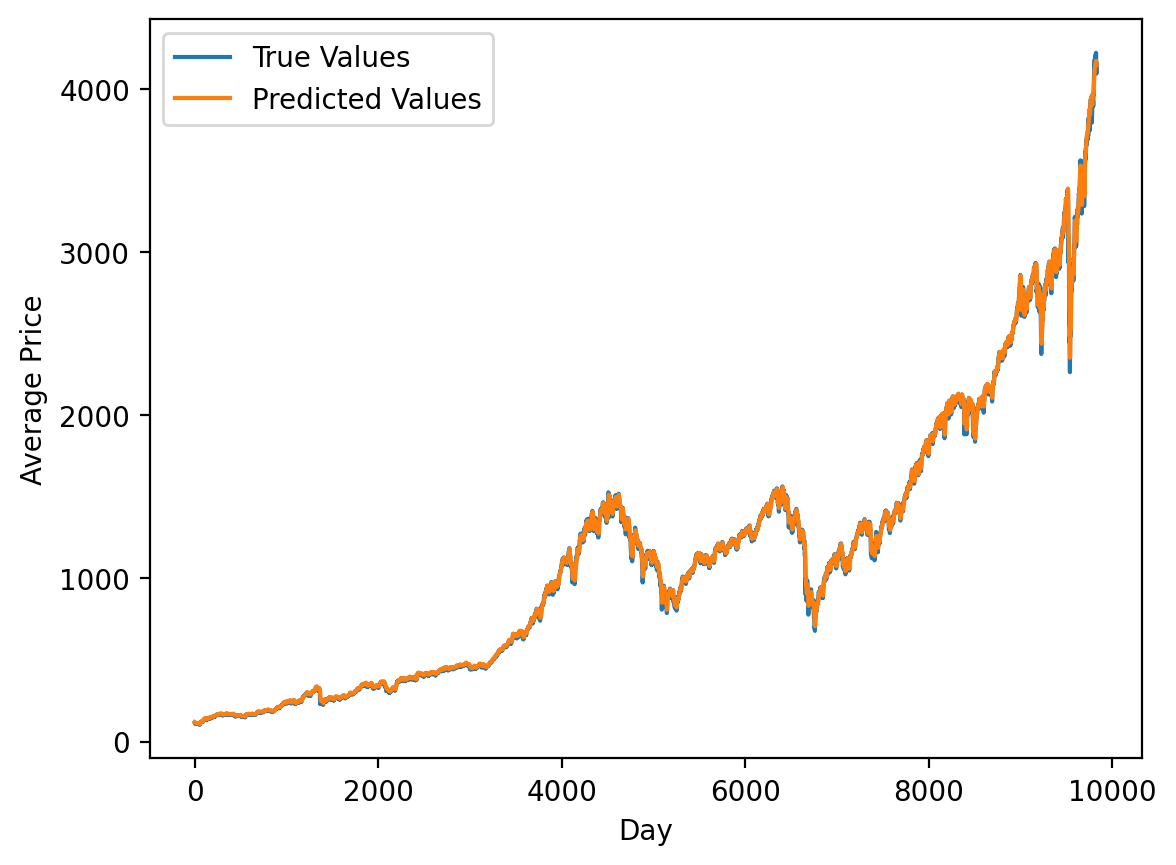

In [26]:
plt.plot(new_y_train, label='True Values')
plt.plot(train_predictions, label='Predicted Values')
plt.xlabel('Day')
plt.ylabel('Average Price')
plt.legend()
plt.show()

Obtaining the predicted values in their original scale for the testing set.

In [27]:
# Make predictions on the testing data.
test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()

dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])

Obtaining the true values in their orginal scale for the testing set.

In [28]:
dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = y_test.flatten().to('cpu')
dummies = scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])

Plotting results on the testing set

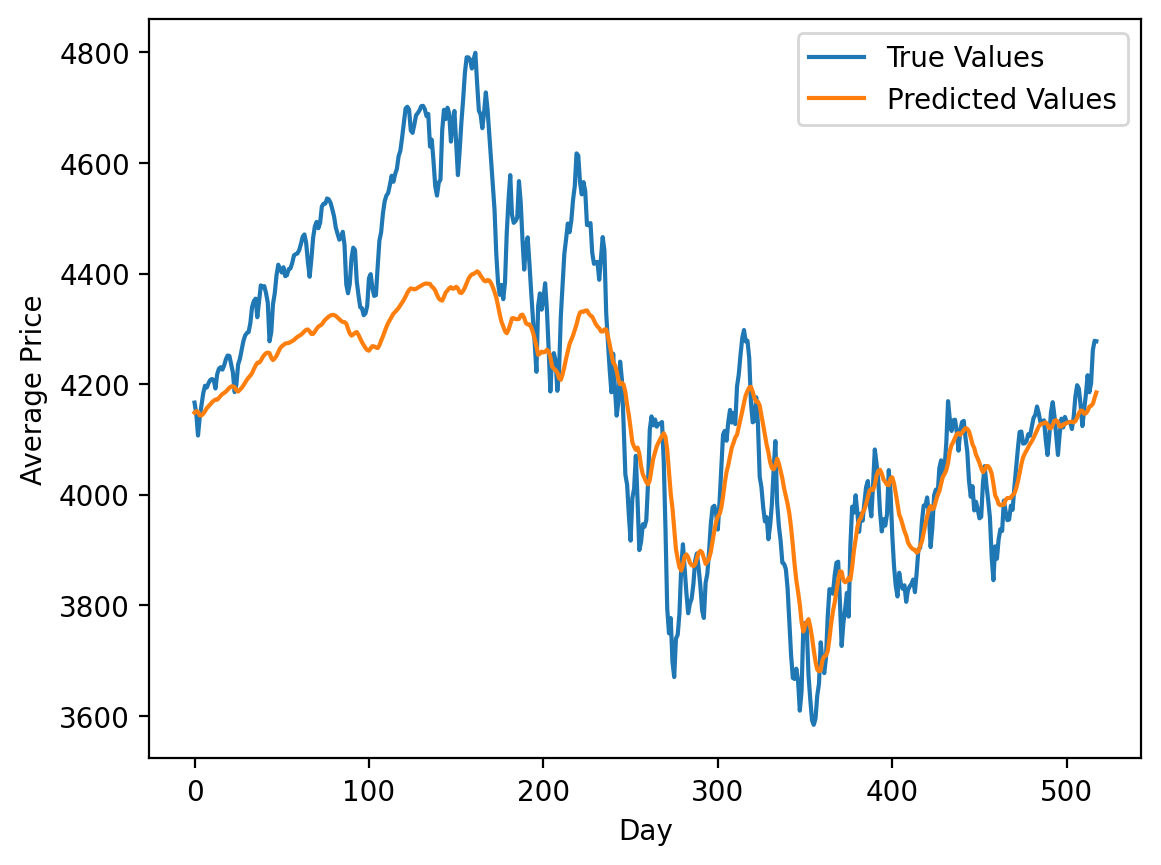

In [29]:
plt.plot(new_y_test, label='True Values')
plt.plot(test_predictions, label='Predicted Values')
plt.xlabel('Day')
plt.ylabel('Average Price')
plt.legend()
plt.show()

Average Price Prediction for End Date Specified

In [30]:
print(f'Average Price Prediction for {end_date}: {test_predictions[-1]}')

Average Price Prediction for 2023-06-07: 4184.9208645746585
